<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [126]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [127]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = './data/' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [128]:
import time

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # загружаем список файлов и частоты
    files = sorted(glob(path_to_csv_files + '/*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_id_freq = pickle.load(f)
    
    # сюда будем записывать сессии
    data = []
    
    # будем считывать по session_length записей с каждого файла с окном window_size
    for file in tqdm(files):
        temp = pd.read_csv(file, header=0)
        len_file = temp.shape[0]
        
        user_id = int(file.split('/')[-1][4:8])
        temp['datetime'] = pd.to_datetime(temp['timestamp'])
        temp['timestamp'] = temp.datetime.astype('int')
        
        for batch in range(int(len_file/window_size)+1):
            if batch*window_size == len_file:
                break
            left = batch*window_size
            right = left+session_length
            if right > len_file:
                right = len_file
            
            row = list(temp.site[left:right].values)
            for index, site in enumerate(row):
                row[index] = site_id_freq[site][0] 
            # добавляем нули, если длина сессии меньше 10
            row.extend([0] * (session_length - len(row)))
            
            # продолжительность сессии
            session_timespan = (temp.timestamp[right-1] - temp.timestamp[left])//10**9
            row.append(session_timespan)
            # число уникальных сайтов в сессии
            unique_sites = temp.site[left:right].value_counts().count()
            row.append(unique_sites)
            # час начала сессии
            start_hour = temp.datetime[left].hour
            row.append(start_hour)
            # день недели
            day_of_week = temp.datetime[left].dayofweek
            row.append(day_of_week)
            # добавляем айдишник пользователя
            row.append(user_id)
            data.append(row)
            
    # создаем data frame
    return pd.DataFrame(data, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [129]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 3/3 [00:00<00:00, 121.05it/s]


In [130]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,1,1,9,1,2,11,5,10,8,7998,8,9,4,1
1,4,2,2,2,0,0,0,0,0,0,60,2,12,4,1
2,4,1,6,6,1,0,0,0,0,0,7935,3,9,4,2
3,3,2,1,2,1,2,2,5,7,3,7998,5,9,4,3
4,3,2,1,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [131]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 10/10 [00:18<00:00,  1.77s/it]

CPU times: user 18.2 s, sys: 181 ms, total: 18.4 s
Wall time: 18.5 s


In [132]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,193,584,133,3,133,133,3,133,204,133,33,5,8,4,31
1,415,192,693,257,133,31,400,4377,220,55,284,10,8,4,31
2,55,3,55,55,5,295,415,334,925,55,258,7,8,4,31
3,486,4203,486,55,55,55,55,963,200,124,30,6,8,4,31
4,343,55,5,4381,261,211,4281,2503,704,2503,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [133]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 150/150 [03:30<00:00,  1.00s/it]


CPU times: user 3min 19s, sys: 3.34 s, total: 3min 22s
Wall time: 3min 31s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [135]:
features_new = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[features_new].values
new_features_150users = train_data_150users[features_new].values

In [136]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [138]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [139]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0x1354a50d0>, <matplotlib.text.Text at 0x1317faa10>]

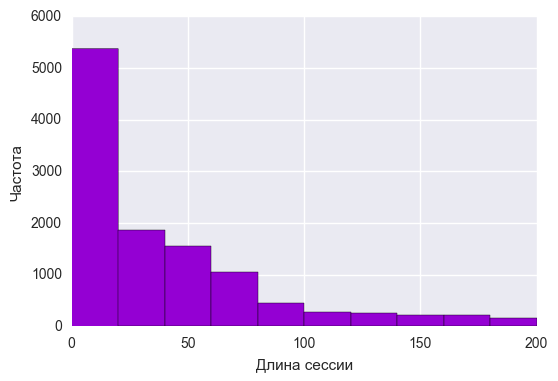

In [207]:
ax = train_data_10users[train_data_10users.session_timespan <= 200]['session_timespan'].hist(color='darkviolet')
ax.set_xlim([0,200])
ax.set(xlabel=u'Длина сессии', ylabel=u'Частота')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0x12bfb7a10>, <matplotlib.text.Text at 0x12d872a10>]

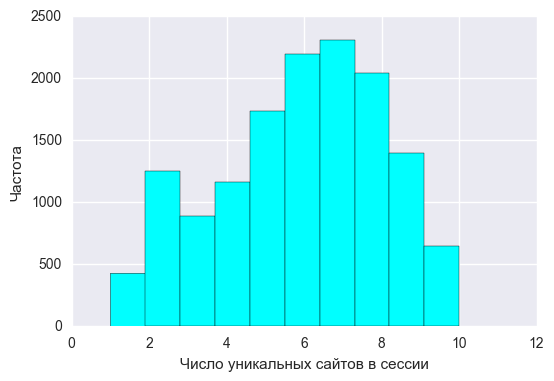

In [162]:
ax = train_data_10users['#unique_sites'].hist(color='aqua')
ax.set(xlabel=u'Число уникальных сайтов в сессии', ylabel=u'Частота')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

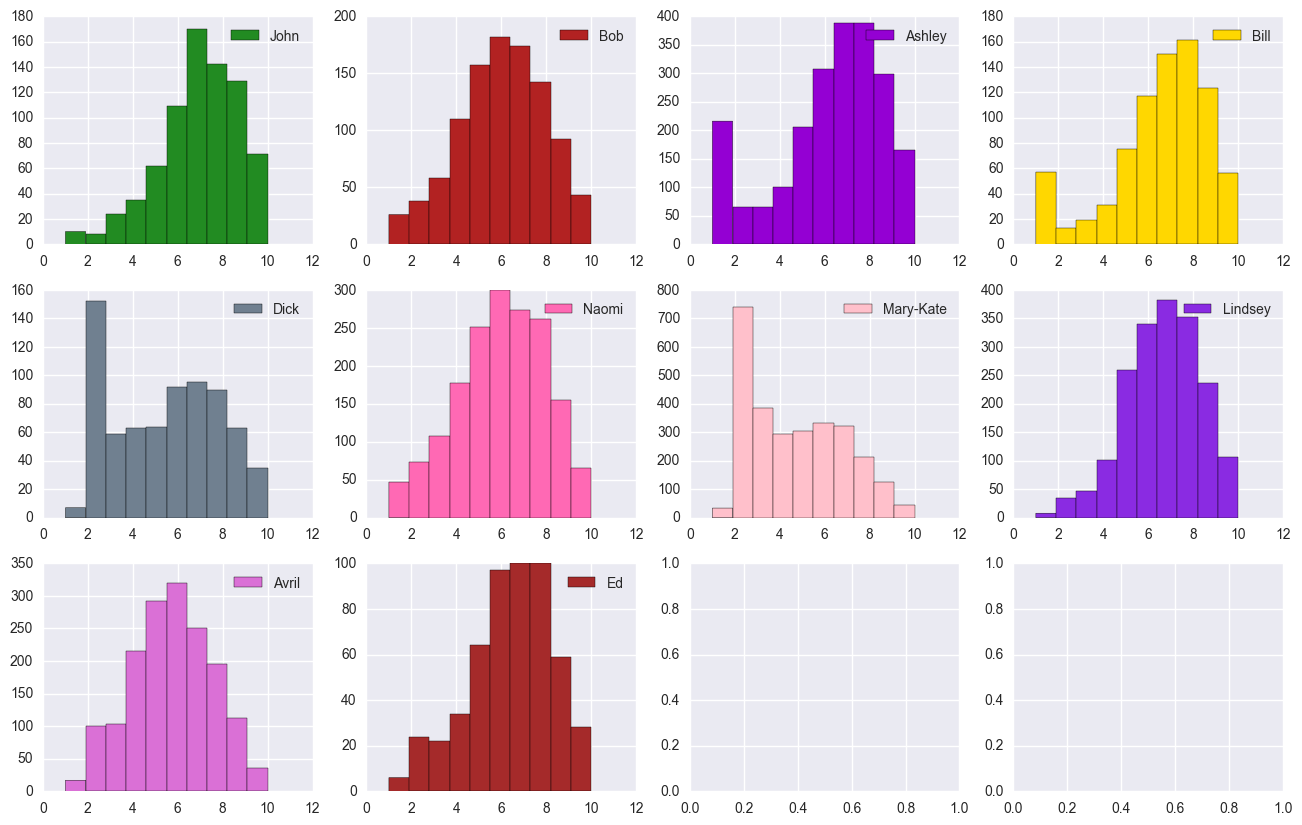

In [191]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    ax = sub_df['#unique_sites'].hist(ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0x11a9dbb50>, <matplotlib.text.Text at 0x11cbe5790>]

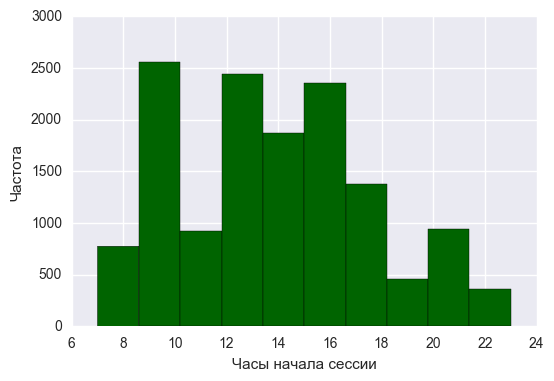

In [193]:
ax = train_data_10users['start_hour'].hist(color='darkgreen')
ax.set(xlabel=u'Часы начала сессии', ylabel=u'Частота')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

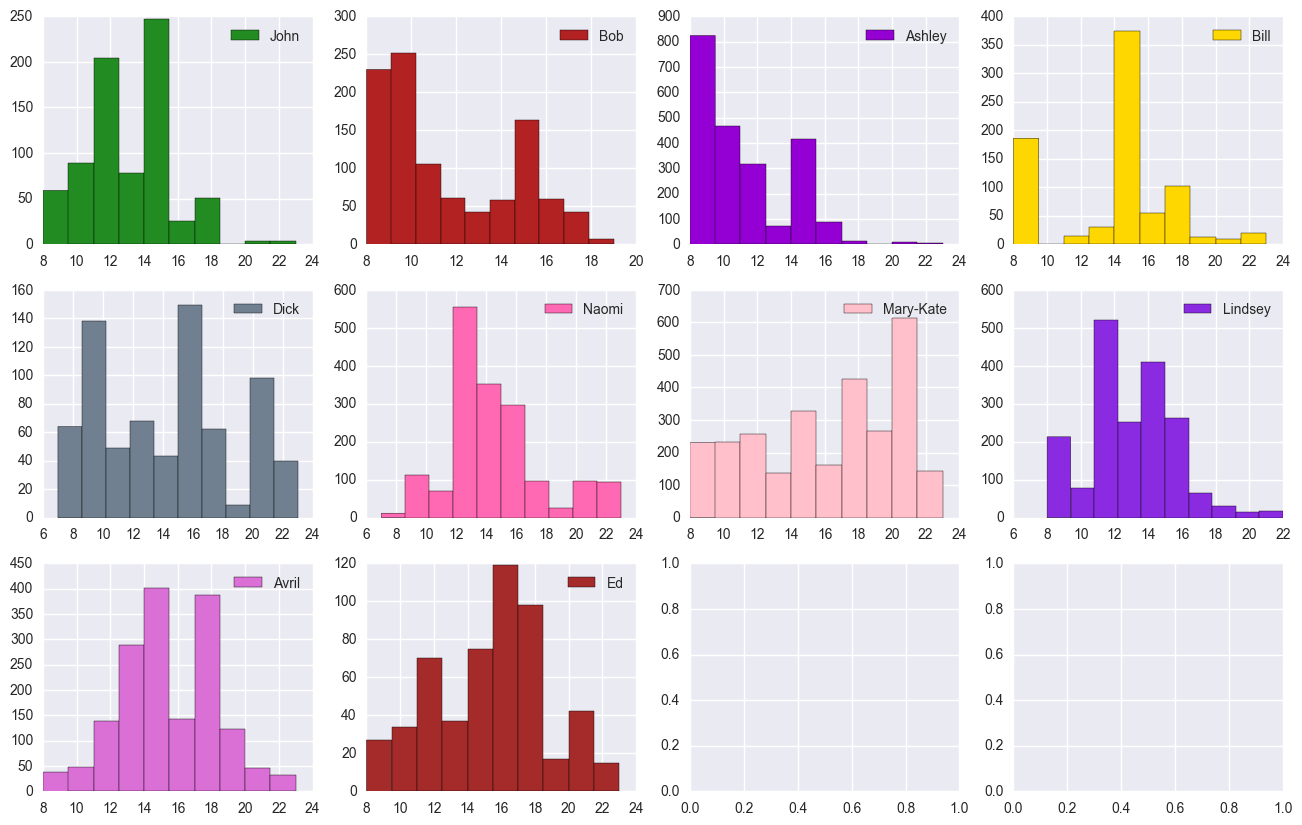

In [195]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    ax = sub_df['start_hour'].hist(ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

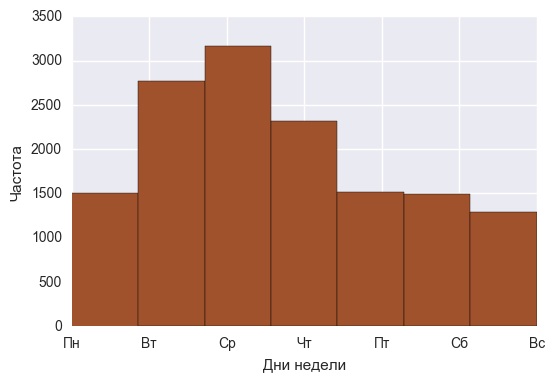

In [200]:
days = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

ax = train_data_10users['day_of_week'].hist(bins=7, color='sienna')
ax.set(xlabel=u'Дни недели', ylabel=u'Частота')
ax.set_xticklabels(days)

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

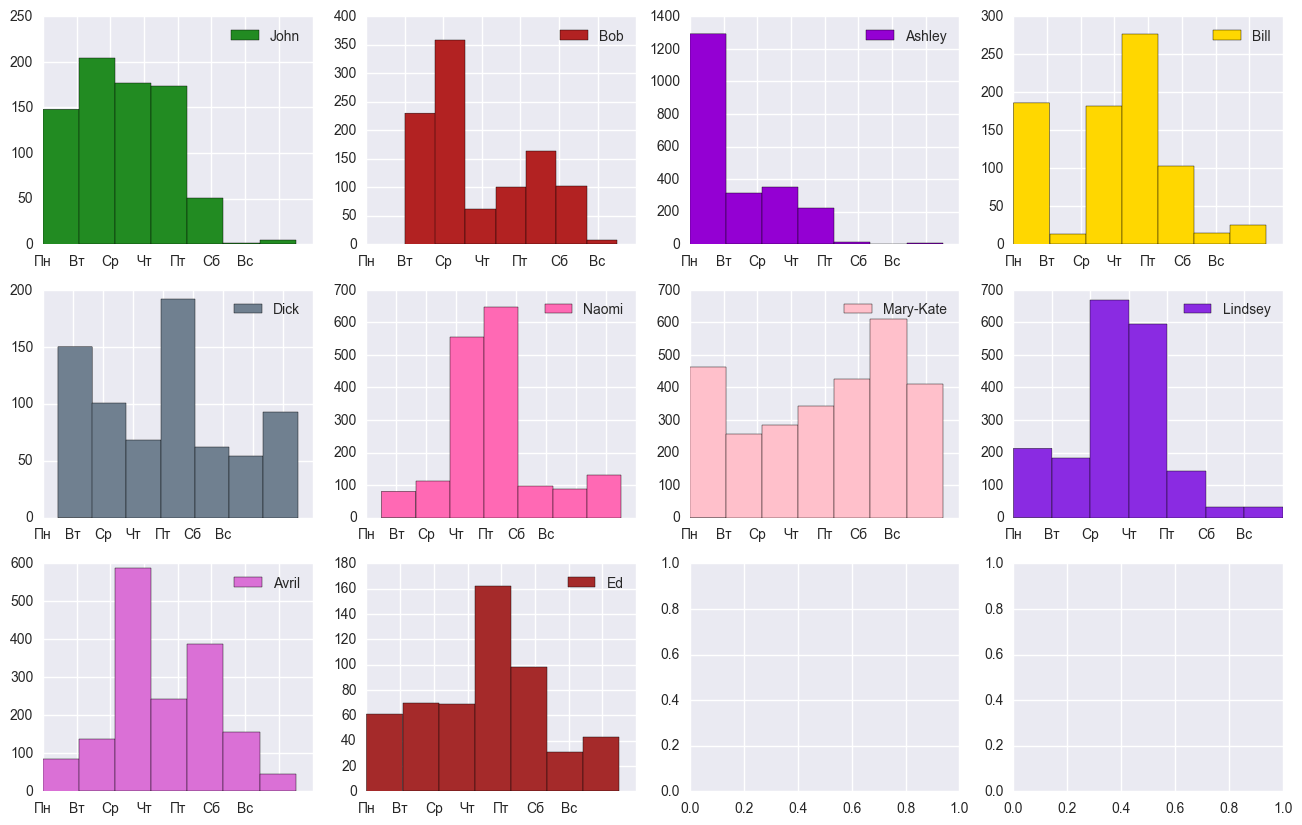

In [201]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    ax = sub_df['start_hour'].hist(bins=7, ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])
    ax.set_xticklabels(days)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* **John**: число уникальных сайтов в сессии - 7-9, часы начала сессии - пик на день (12-14 часов), дни недели - пн-чт основные.
* **Bob**: число уникальных сайтов - 5-8, часы начала сессии - пики на утро (8-10), после обеда (14-15), дни недели - основнйо пик на начало недели (пн-вт).
* **Ashley**: число уникальных сайтов - 7-8 и есть пик на единице, часы начала сессии - пики на утро (8-10), после обеда (14-15), дни недели - пик на понедельник.
* **Bill**: число уникальных сайтов - 6-8, есть небольшой пик на 1, часы начала сессии - преобладает утро (8-9) и время после обеда (14-15), дни недели - популярные будние дни, кроме вторника.
* **Dick**: число уникальных сайтов - есть большой пик на 2-ке, а также 6-8, часы начала сессии - есть пики на 809 часов, 15-16 часов, 20-21, дни недели - более менее равномерны, пика на пн и чт.
* **Naomi**: число уникальных сайтов в сессии - 5-8, часы начала сессии - основные в 12-16 часов, дни недели - популярные дни среда и четверг.
* **Mary-Kate**: число уникальных сайтов скошено влево, наиболее частое значение - 2, часы начала сессии - более менее равномерны, есть пик на 20-21, дни недели - более менее равномерно.
* **Lindsey**: число уникальных сайтов - 6-8, часы начала сессии - преобладает 12-16 часов, дни недели - популярны среда и четверг.
* **Avril**: число уникальных сайтов - 5-8, часы начала сессии - есть пик на 13-15 и на 18-19, дни недели - популярны ср и пт.
* **Ed**: число уникальных сайтов - 6-8, часы начала сессии - основной пик на 14-17 часов, дни недели - более менее равномерны, популярен четверг.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [210]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
        site_id_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [214]:
sorted_sites = sorted(site_id_freq.iteritems(), key=lambda x: x[1])[0:10]

In [219]:
top10_freqs = [x[1][1] for x in sorted_sites]
top10_sites = [x[0] for x in sorted_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

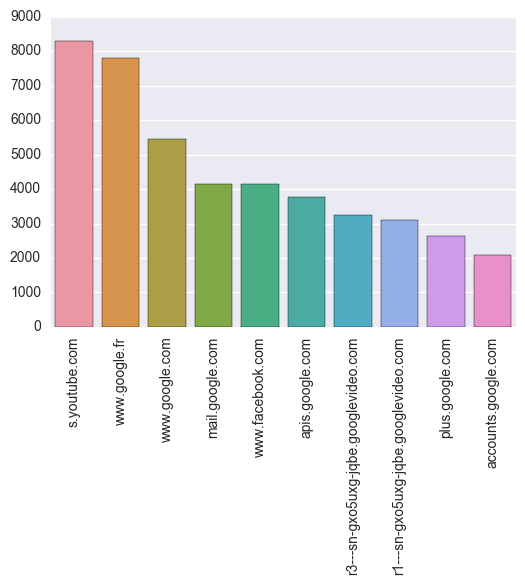

In [229]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90) 

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [230]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [231]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [232]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [233]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Итак, будем генерировать следующие признаки:
* среднее время пребывания на сайте за сессию
* месяц начала сессии
* посещение сайтов из топ-30 (счетчик - количество посещенных сайтов за сессию из топ 30)
* посещение youtube в сессии (бинарный признак)
* посещение поисковика google в сессии (бинарный признак)
* посещение facebook в сессии (бинарный признак)

Будем создавать датафрейм и со старыми и с новыми признаками.

In [286]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10):
    # загружаем список файлов и частоты
    files = sorted(glob(path_to_csv_files + '/*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_id_freq = pickle.load(f)
        
    # заранее посчитаем топ-30 сайтов
    top_30 = sorted(site_id_freq.iteritems(), key=lambda x: x[1])[0:30]
    top_30_sites = [x[0] for x in top_30]
    
    # сюда будем записывать признаки
    data = []
    
    # будем считывать по session_length записей с каждого файла с окном window_size
    for file in tqdm(files):
        temp = pd.read_csv(file, header=0)
        len_file = temp.shape[0]
        
        user_id = int(file.split('/')[-1][4:8])
        temp['datetime'] = pd.to_datetime(temp['timestamp'])
        temp['timestamp'] = temp.datetime.astype('int')
        
        for batch in range(int(len_file/window_size)+1):
            if batch*window_size == len_file:
                break
            left = batch*window_size
            right = left+session_length
            if right > len_file:
                right = len_file
            
            row = list(temp.site[left:right].values)
            for index, site in enumerate(row):
                row[index] = site_id_freq[site][0] 
            # добавляем нули, если длина сессии меньше 10
            row.extend([0] * (session_length - len(row)))
            
            # продолжительность сессии
            session_timespan = (temp.timestamp[right-1] - temp.timestamp[left])//10**9
            row.append(session_timespan)
            # число уникальных сайтов в сессии
            unique_sites = temp.site[left:right].value_counts().count()
            row.append(unique_sites)
            # час начала сессии
            start_hour = temp.datetime[left].hour
            row.append(start_hour)
            # день недели
            day_of_week = temp.datetime[left].dayofweek
            row.append(day_of_week)
            
            # среднее время пребывания на сайте (mean_time_session)
            mean_time_session = session_timespan/(right-left)
            row.append(mean_time_session)
            
            # месяц сессии (month)
            month = temp.datetime[left].month
            row.append(month)
            
            # посещение сайта из топ-30 (visited_top_30)
            visited_top_30 = len(set(temp.site[left:right].values).intersection(top_30_sites))
            row.append(visited_top_30)

            # посещение youtube (visited_youtube)
            visited_youtube = len(set(temp.site[left:right].values).intersection(['www.youtube.com', 's.youtube.com']))
            row.append(int(visited_youtube > 0))
            
            # посещение google (visited_google)
            visited_google = len(set(temp.site[left:right].values).intersection(['www.google.fr', 'www.google.com']))
            row.append(int(visited_google > 0))
            
            # посещение facebook (visited_facebook)
            visited_facebook = len(set(temp.site[left:right].values).intersection(['www.facebook.com']))
            row.append(visited_facebook)
            
            # добавляем айдишник пользователя
            row.append(user_id)
            data.append(row)
            
    # создаем data frame
    return pd.DataFrame(data, columns=features)

new_features = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'mean_time_session', 'month', 'visited_top_30', 
                 'visited_youtube', 'visited_google', 'visited_facebook', 'user_id']

feature_engineering(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  features=new_features, session_length=10, window_size=10)



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 59.81it/s]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,mean_time_session,month,visited_top_30,visited_youtube,visited_google,visited_facebook,user_id
0,4,1,1,9,1,2,11,5,10,8,7998,8,9,4,799.800000,11,8,0,0,0,1
1,4,2,2,2,0,0,0,0,0,0,60,2,12,4,15.000000,11,2,0,0,0,1
2,4,1,6,6,1,0,0,0,0,0,7935,3,9,4,1587.000000,11,3,0,0,0,2
3,3,2,1,2,1,2,2,5,7,3,7998,5,9,4,799.800000,11,5,0,0,0,3
4,3,2,1,0,0,0,0,0,0,0,1471,3,12,4,490.333333,11,3,0,0,0,3


In [287]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  features=new_features, session_length=10, window_size=10)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:14,  1.58s/it]

 20%|██        | 2/10 [00:03<00:13,  1.72s/it]


 30%|███       | 3/10 [00:08<00:18,  2.58s/it]

 40%|████      | 4/10 [00:10<00:14,  2.37s/it]

 50%|█████     | 5/10 [00:11<00:10,  2.08s/it]

 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

 70%|███████   | 7/10 [00:21<00:11,  3.67s/it]

 80%|████████  | 8/10 [00:26<00:08,  4.17s/it]

 90%|█████████ | 9/10 [00:30<00:04,  4.07s/it]

100%|██████████| 10/10 [00:31<00:00,  3.20s/it]



In [288]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  features=new_features, session_length=10, window_size=10)

100%|██████████| 150/150 [05:03<00:00,  1.40s/it]


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Построим гистограмму для среднего времени пребывания на сайте.

[<matplotlib.text.Text at 0x13652ba10>, <matplotlib.text.Text at 0x1363c6310>]

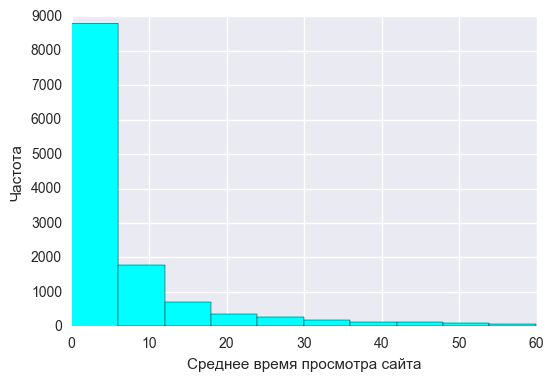

In [294]:
ax = new_features_10users[new_features_10users.mean_time_session < 60]['mean_time_session'].hist(color='aqua')
ax.set(xlabel=u'Среднее время просмотра сайта', ylabel=u'Частота')

Характер распределения очень похож на длину сессии, что в принципе логично.

Теперь рассмотрим распределение месяца.

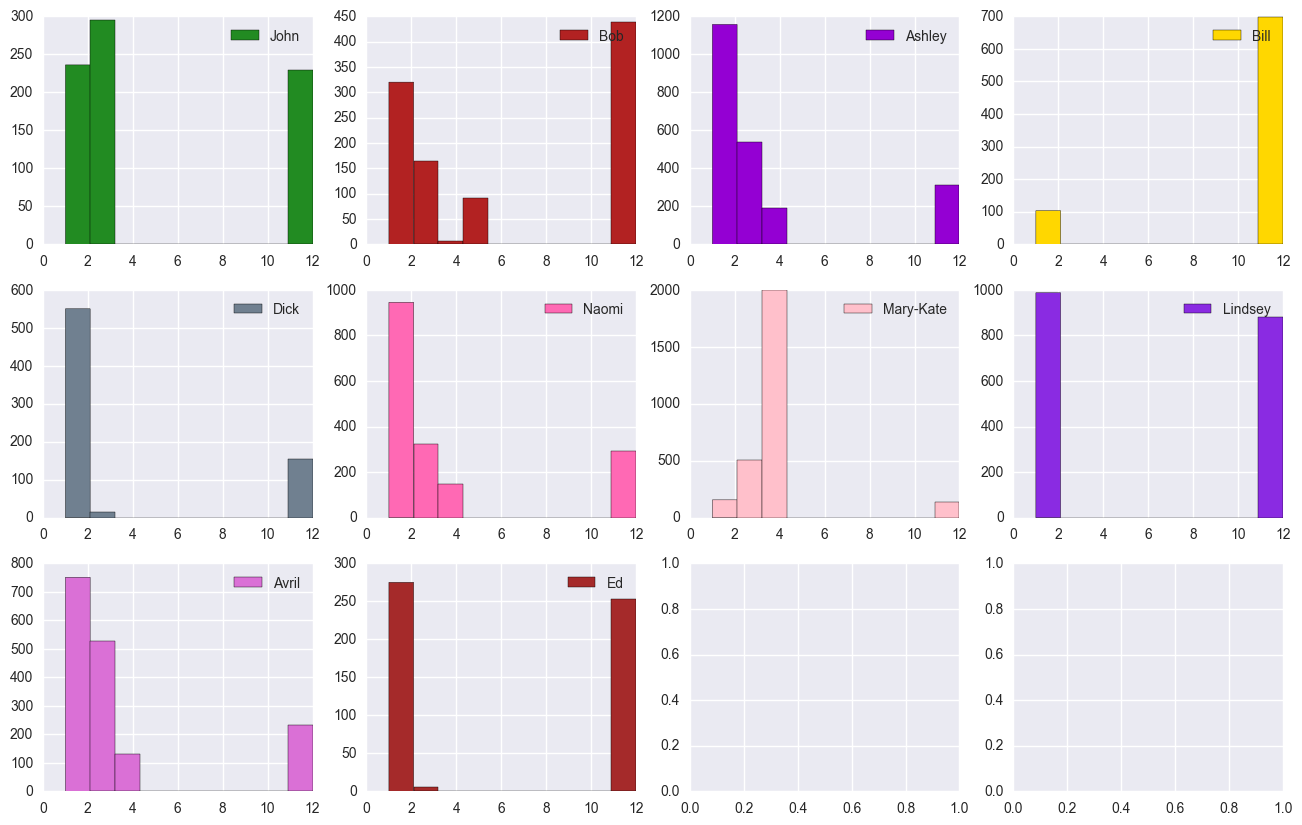

In [303]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    ax = sub_df['month'].hist(ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

Видно, что по всем пользователям есть данные за конец года и за начало следующего. Соотношение этих данных по месяцам разное.

Рассмотрим признак - посещение сайтов топ-30 (счетчик).

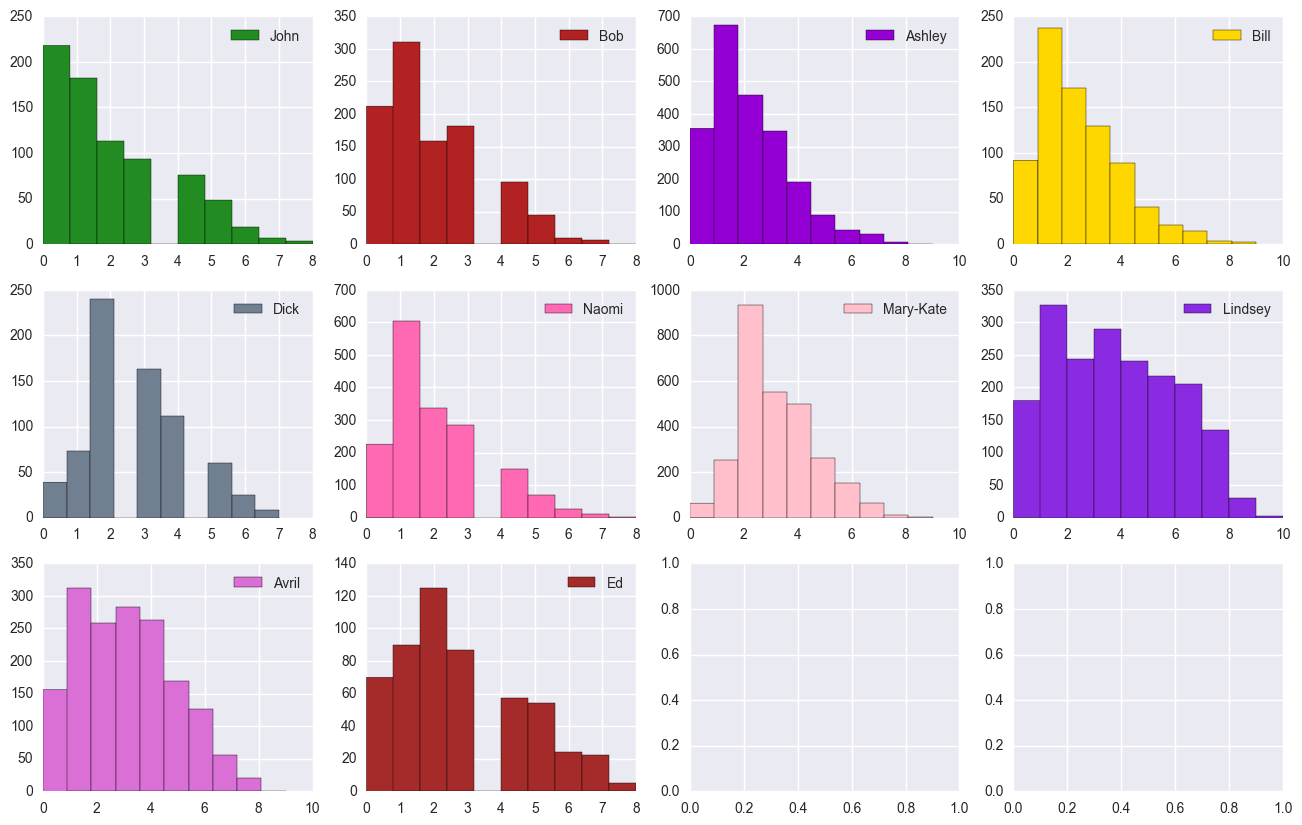

In [302]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    ax = sub_df['visited_top_30'].hist( ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

В целом пользователи достаточно похожи по этому признаку, но у некоторых пик распределения приходится на разное количество сайтов.

Рассмотрим признак visited_youtube.

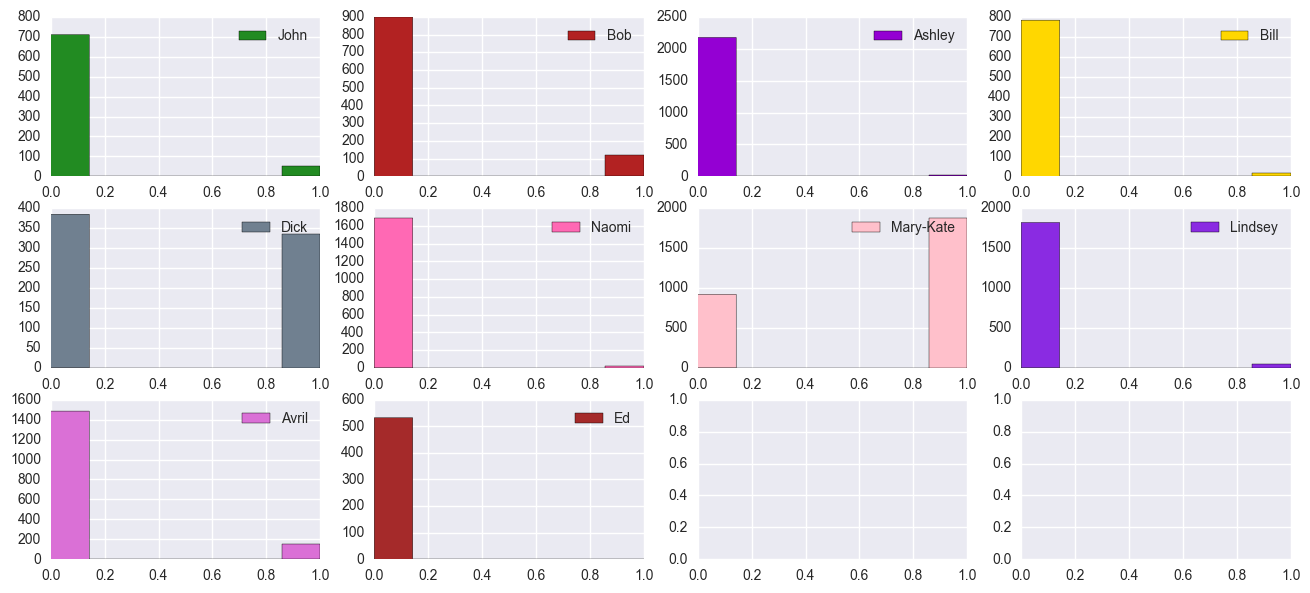

In [307]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 7))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    ax = sub_df['visited_youtube'].hist(bins=7, ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

Видны, как минимум, два любителя youtube.

Рассмотрим признак visited_google.

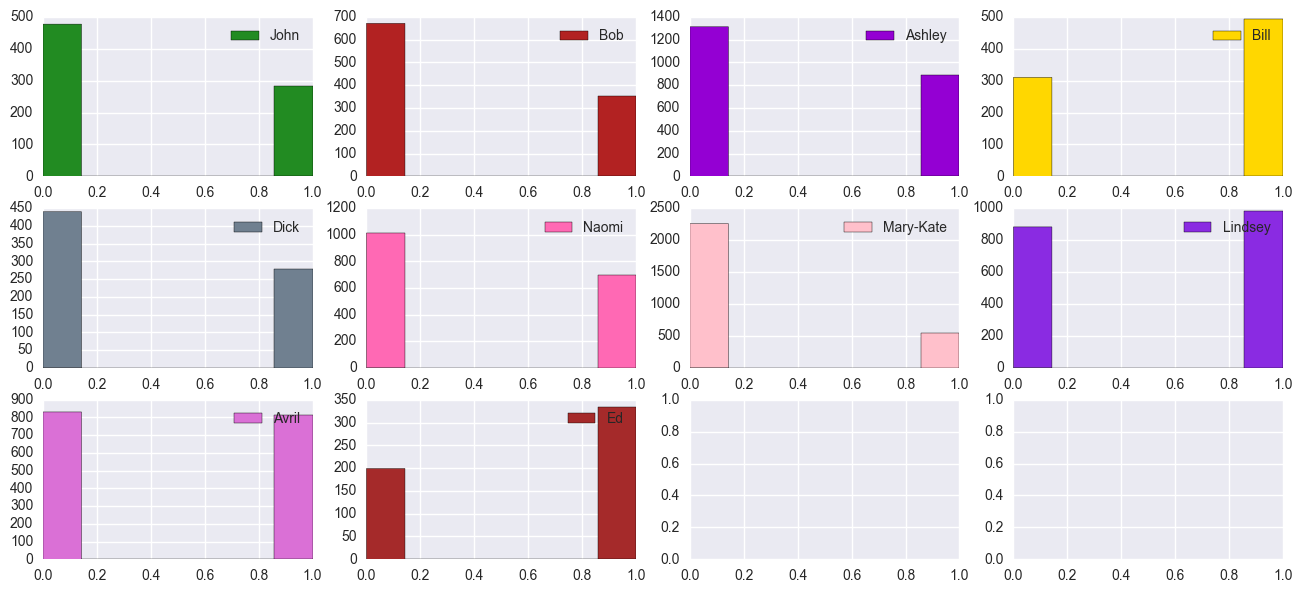

In [309]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 7))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    ax = sub_df['visited_google'].hist(bins=7, ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

Видно, что google пользутся все, но с разной частотой.

И рассмотрми последний признак visited_facebook.

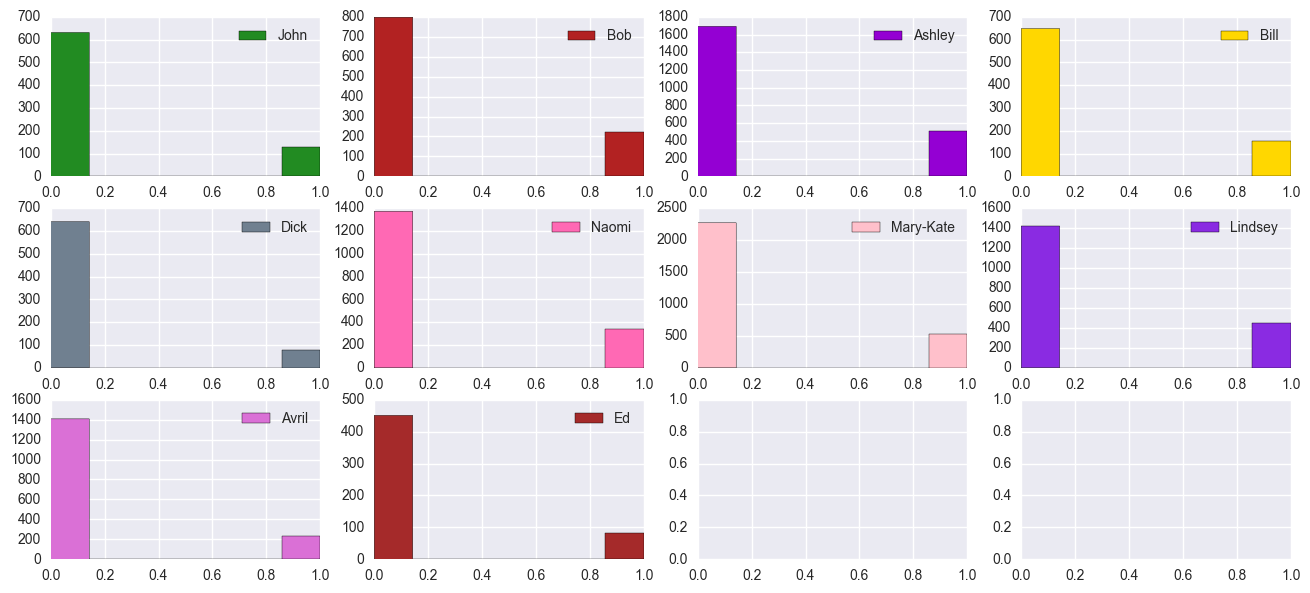

In [310]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 7))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    ax = sub_df['visited_facebook'].hist(bins=7, ax=axes[int(idx/4),idx%4], color=color_dic[id_name_dict[user]])
    ax.legend([id_name_dict[user]])

Для некоторых пользователей также есть различия. Но все, так или иначе, заходят на фейсбук.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [311]:
selected_features = ['session_timespan', '#unique_sites', 'start_hour', 
                     'day_of_week', 'mean_time_session', 'month', 'visited_top_30', 
                     'visited_youtube', 'visited_google', 'visited_facebook', 'user_id']
selected_features_10users = new_features_10users[selected_features].values
selected_features_150users = new_features_150users[selected_features].values

In [312]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 